In [1]:
from torch import nn
import matplotlib.pyplot as plt
from torchsummary import summary

import lightdde as dde
from essential import *
from qmodels import *

# Inference

In [2]:
data = dde.data.PDEData(
    domain=domain,
    pde=pde,
    bcs=[boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    exact_solution=[u_func, v_func, p_func],
    num_domain=2601,
    num_bc=400,
    num_test=5000,
)

# Models (pick one!)

## classic model

In [3]:
net = ClassicNet(in_dim=2, out_dim=3, hidden_dim=16,)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/classic_1000e_tanh/",
    log_every=10,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## FNN model

In [16]:
net = FNN()

model = dde.Model(
    data=data,
    model=net,
    save_path="models/FNN_1000e_tanh/",
    log_every=100,
    save_every=100,
)

model.compile()

Loaded snapshot at epoch 1000


## quantum model

In [6]:
net = QuantumNet(in_dim=2, out_dim=3, activation=nn.SiLU)

model = dde.Model(
    data=data,
    model=net,
    save_path="models/quantum_2000e_silu/",
    log_every=20,
    save_every=10,
)

model.compile()

Loaded snapshot at epoch 2000


In [7]:
summary(net, input_size=(1, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        TorchLayer-1                    [-1, 2]               0
            Linear-2                    [-1, 1]               3
           QScalar-3                    [-1, 1]               0
            Linear-4                   [-1, 10]              30
              SiLU-5                   [-1, 10]               0
            Linear-6                   [-1, 10]             110
              SiLU-7                   [-1, 10]               0
            Linear-8                    [-1, 1]              11
           CScalar-9                    [-1, 1]               0
       TorchLayer-10                    [-1, 2]               0
           Linear-11                    [-1, 1]               3
          QScalar-12                    [-1, 1]               0
           Linear-13                   [-1, 10]              30
             SiLU-14                   

# Plotting

Executed in 58.03 sec.


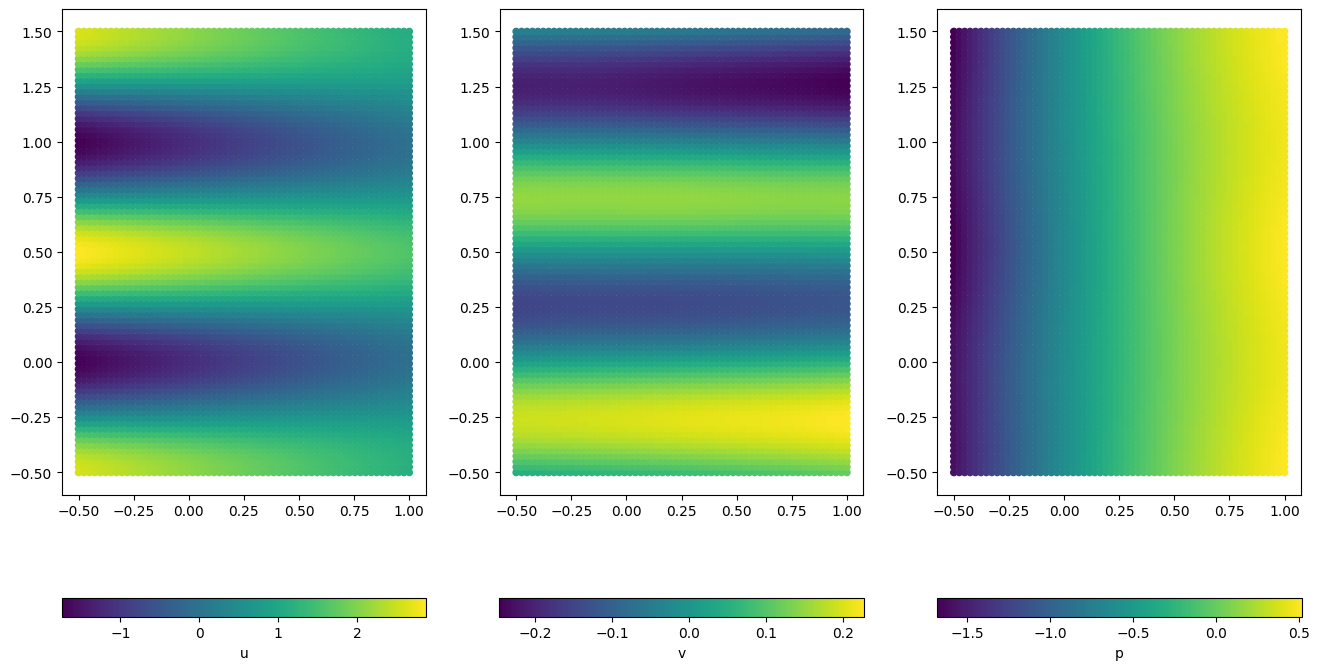

''

In [8]:
dde.scatter_plot(model, s=20)
;

# Load csv loss

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df_q_silu = pd.read_csv("models/quantum_2000e_silu/log.csv", index_col="epoch")
df_q_relu = pd.read_csv("models/quantum_2000e_relu/log.csv", index_col="epoch")

In [11]:
df_q_silu.tail()

,loss_train,u_err,v_err,p_err
epoch,,,,
1920,0.244291,0.623615,0.146672,0.437886
1940,0.244127,0.623291,0.146723,0.437608
1960,0.243962,0.622962,0.146775,0.437326
1980,0.243797,0.622628,0.146826,0.437040
2000,0.243633,0.622289,0.146878,0.436751


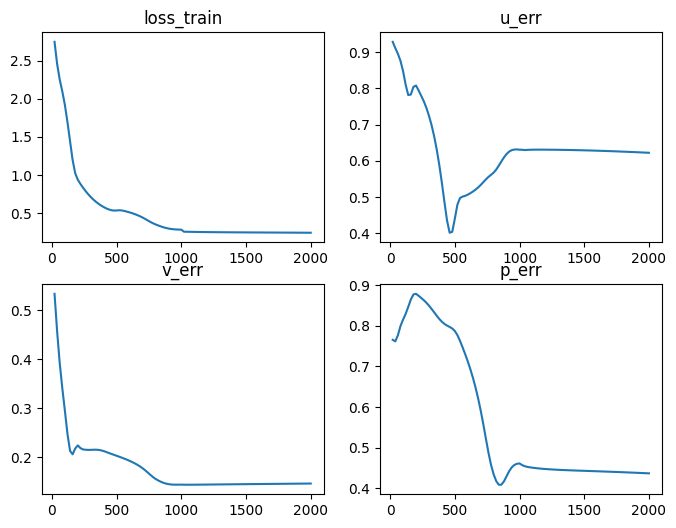

In [12]:
errs = ["loss_train", "u_err", "v_err", "p_err"]

plt.figure(figsize=(8, 6))
for i, err in enumerate(errs):
    plt.subplot(2, 2, i+1)
    plt.plot(df_q_silu.index, df_q_silu[err])
    plt.title(err)
plt.show()

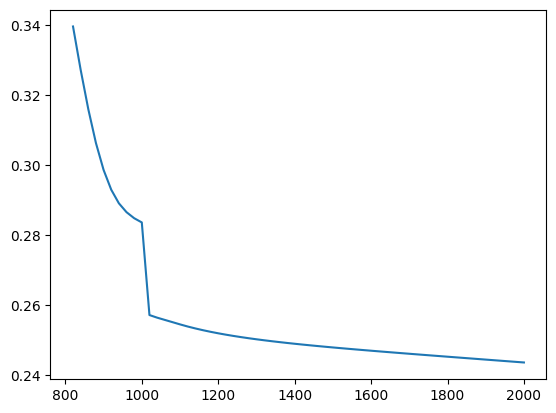

In [13]:
plt.plot(df_q_silu["loss_train"].iloc[40:])

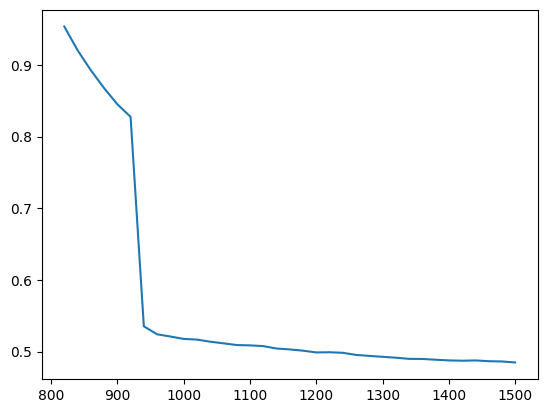

In [14]:
plt.plot(df_q_relu["loss_train"].iloc[40:75])

In [15]:
df_q_silu["loss_train"].iloc[40:]

epoch
820     0.339679
840     0.327294
860     0.316033
880     0.306354
900     0.298675
920     0.293020
940     0.289136
960     0.286598
980     0.284875
1000    0.283665
1020    0.257190
1040    0.256451
1060    0.255807
1080    0.255168
1100    0.254522
1120    0.253916
1140    0.253365
1160    0.252861
1180    0.252399
1200    0.251974
1220    0.251582
1240    0.251218
1260    0.250879
1280    0.250561
1300    0.250263
1320    0.249981
1340    0.249714
1360    0.249459
1380    0.249216
1400    0.248983
1420    0.248759
1440    0.248542
1460    0.248332
1480    0.248128
1500    0.247929
1520    0.247735
1540    0.247546
1560    0.247359
1580    0.247176
1600    0.246996
1620    0.246818
1640    0.246642
1660    0.246468
1680    0.246296
1700    0.246125
1720    0.245955
1740    0.245786
1760    0.245618
1780    0.245450
1800    0.245283
1820    0.245117
1840    0.244952
1860    0.244786
1880    0.244621
1900    0.244456
1920    0.244291
1940    0.244127
1960    0.243962
1980    

In [22]:
df_q_relu["loss_train"].iloc[40:]

epoch
820     0.953584
840     0.920552
860     0.892598
880     0.867685
900     0.845172
920     0.827480
940     0.535383
960     0.524215
980     0.521134
1000    0.517772
1020    0.516849
1040    0.513888
1060    0.511637
1080    0.509202
1100    0.508762
1120    0.507759
1140    0.504376
1160    0.503103
1180    0.501387
1200    0.498912
1220    0.499172
1240    0.498415
1260    0.495437
1280    0.494103
1300    0.492805
1320    0.491573
1340    0.489950
1360    0.489809
1380    0.488762
1400    0.487793
1420    0.487347
1440    0.487769
1460    0.486691
1480    0.486329
1500    0.484902
1520    0.484259
1540    0.484673
1560    0.483224
1580    0.481851
1600    0.480761
1620    0.481028
1640    0.482449
1660    0.483057
1680    0.481643
1700    0.480749
1720    0.481694
1740    0.479568
1760    0.480198
1780    0.478858
1800    0.479130
1820    0.482681
1840    0.492759
1860    0.494824
1880    0.522391
1900    0.512971
1920    0.512934
1940    0.514632
1960    0.505826
1980    